In [1]:
from pyforest import*
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import random
from scipy.stats import loguniform
import scipy.stats
import math
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder

# Loading, cheking the data structure, and preprocessing

In [2]:
df1 = pd.read_csv("DEMsExpression.csv")

<IPython.core.display.Javascript object>

In [3]:
cad = pd.read_csv("MI-Healthy DEMs Expression of CAD samples.csv")

<IPython.core.display.Javascript object>

In [4]:
df = pd.concat([df1, cad], axis=0)

<IPython.core.display.Javascript object>

In [5]:
df.head()

,Unnamed: 0,7900488 / MIR30E,7923976 / C1orf132///MIR29B2,7971661 / MIR15A,7976832 / MIR323A,8008885 / MIR21,8045453 / MIR128-1,8084755 / MIR28,8087881 / MIRLET7G,8163107 / MIR32,8175248 / MIR92A2
0,75.GSM1316371.H,5.86237,4.17884,5.93182,3.31011,8.79683,4.71189,3.45519,7.52580,6.67709,3.16477
1,75.GSM1316372.H,5.61056,3.90262,6.09685,3.54984,9.09161,4.82916,3.52235,7.55883,6.60037,3.14140
2,75.GSM1316373.H,6.47634,4.42823,6.45591,3.78296,9.46479,4.56398,3.64562,7.69815,6.91699,3.05517
3,75.GSM1316374.H,6.29086,4.16566,6.38480,3.47636,9.16028,4.41579,3.72838,7.59828,6.30052,3.05037
4,75.GSM1316375.H,5.42813,3.83066,6.30655,3.82938,8.31414,4.49369,3.53013,7.36374,6.18958,2.99243


In [6]:
df.shape

(250, 11)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
7900488 / MIR30E,250.0,7.450548,0.607236,5.356128,7.199537,7.633360,7.867915,8.360230
7923976 / C1orf132///MIR29B2,250.0,5.384517,0.655981,3.628750,5.232723,5.600820,5.820860,6.509030
7971661 / MIR15A,250.0,6.990930,0.600481,5.072702,6.717252,7.124750,7.360918,8.311290
7976832 / MIR323A,250.0,3.548375,0.548304,2.870420,3.200370,3.345095,3.610920,5.171396
8008885 / MIR21,250.0,10.115399,0.952993,6.982273,9.503113,10.320200,10.771200,12.349500
8045453 / MIR128-1,250.0,5.643931,0.556826,4.081839,5.548988,5.816710,6.024390,6.386390
8084755 / MIR28,250.0,5.181250,0.812016,3.365152,5.001390,5.478615,5.723738,6.492950
8087881 / MIRLET7G,250.0,7.821840,0.667161,5.664453,7.559920,7.975815,8.265690,9.254780
8163107 / MIR32,250.0,7.565765,0.821758,4.744559,7.351543,7.817910,8.111895,8.957920
8175248 / MIR92A2,250.0,2.938011,0.435897,2.463260,2.647992,2.757300,2.960275,4.055258


In [8]:
# adding a column to the dataframe containing health status of samples
target = []
for sample in df['Unnamed: 0']:
    if sample[-1] == "H":
        target.append("Healthy")
    elif sample[-1] == "M":
        target.append("MI")
    elif sample[-1] == "C":
        target.append("CAD")

In [9]:
df["MI status"] = target
df.drop('Unnamed: 0', axis=1, inplace = True)
df.head()

,7900488 / MIR30E,7923976 / C1orf132///MIR29B2,7971661 / MIR15A,7976832 / MIR323A,8008885 / MIR21,8045453 / MIR128-1,8084755 / MIR28,8087881 / MIRLET7G,8163107 / MIR32,8175248 / MIR92A2,MI status
0,5.86237,4.17884,5.93182,3.31011,8.79683,4.71189,3.45519,7.52580,6.67709,3.16477,Healthy
1,5.61056,3.90262,6.09685,3.54984,9.09161,4.82916,3.52235,7.55883,6.60037,3.14140,Healthy
2,6.47634,4.42823,6.45591,3.78296,9.46479,4.56398,3.64562,7.69815,6.91699,3.05517,Healthy
3,6.29086,4.16566,6.38480,3.47636,9.16028,4.41579,3.72838,7.59828,6.30052,3.05037,Healthy
4,5.42813,3.83066,6.30655,3.82938,8.31414,4.49369,3.53013,7.36374,6.18958,2.99243,Healthy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

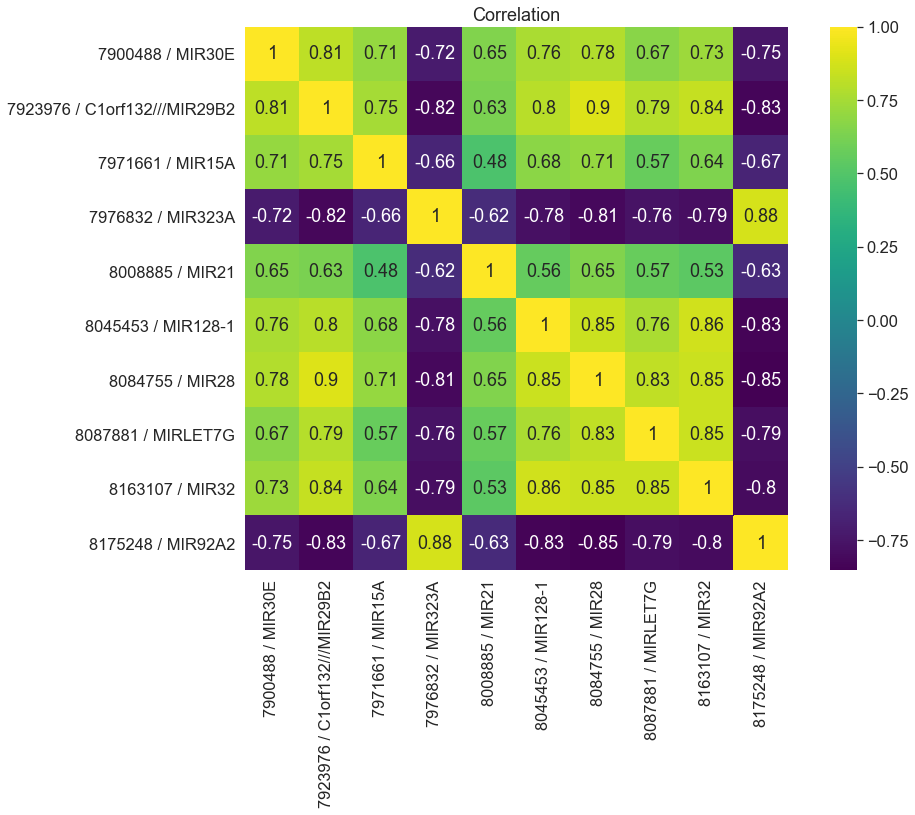

In [ ]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
sns.heatmap(df.corr(),vmax=1,square=True, annot=True, cmap='viridis')
plt.title('Correlation')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

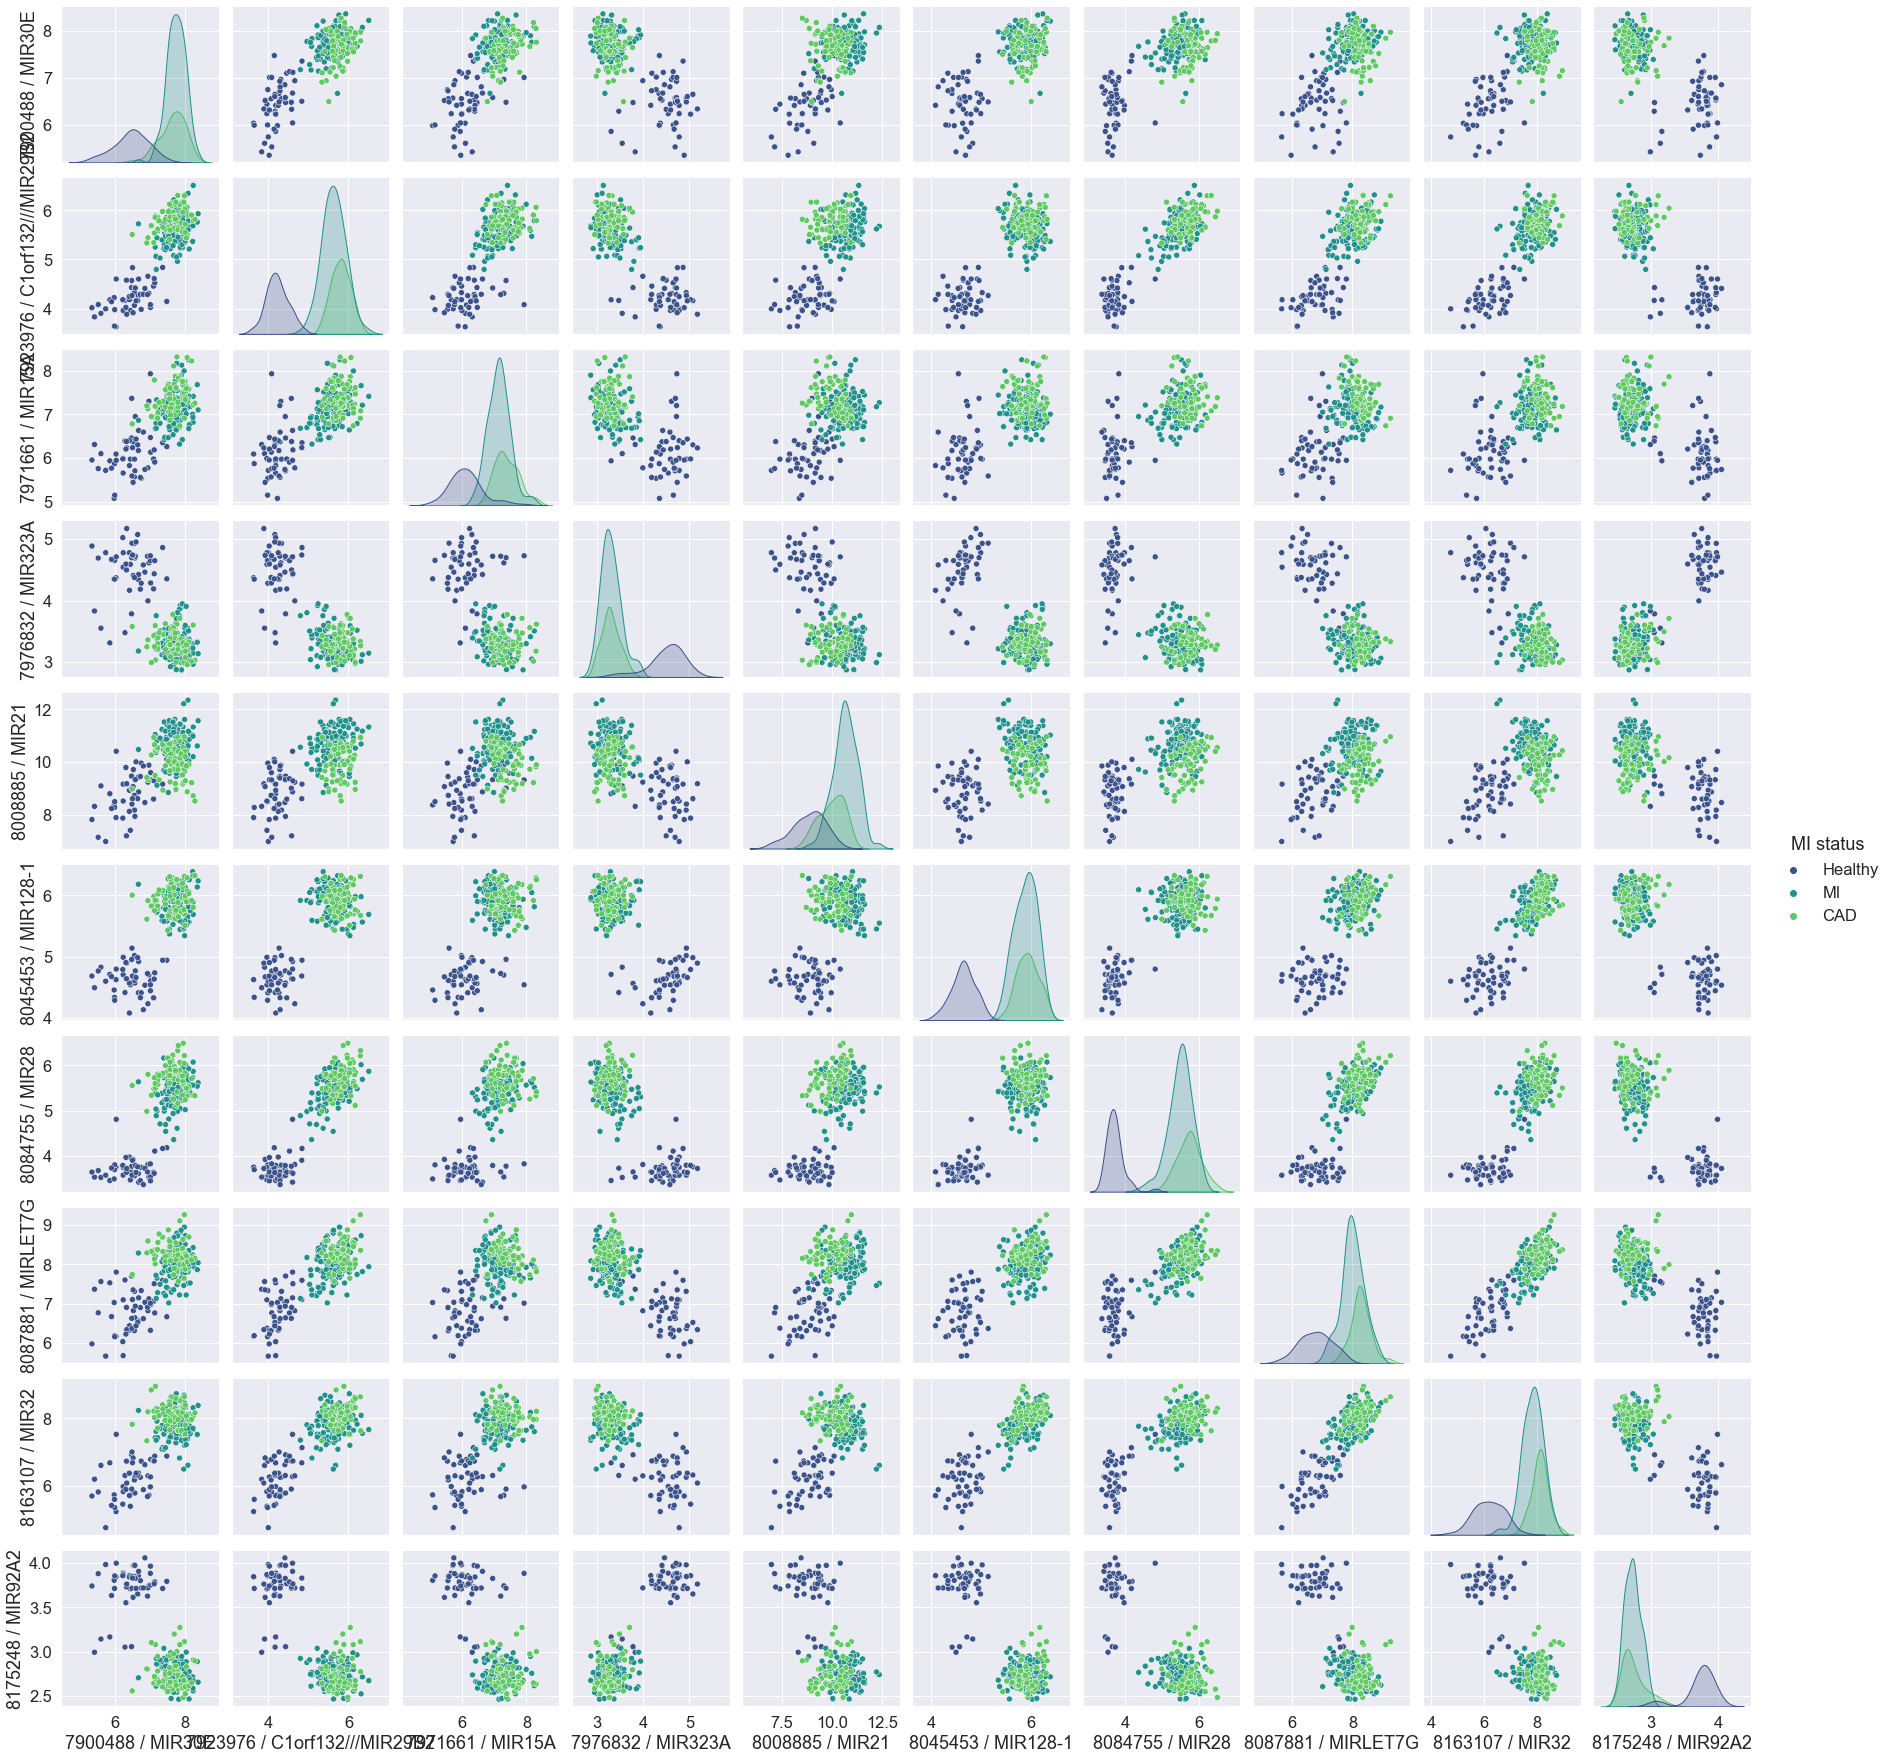

In [ ]:
sns.pairplot(df, hue='MI status', palette="viridis")
plt.savefig("pairplot2.pdf")

In [10]:
df['MI status'].value_counts()

MI         139
CAD         60
Healthy     51
Name: MI status, dtype: int64

# Training a model with all microRNAs

In [11]:
X=df.drop('MI status', axis=1)
y=df['MI status']

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=27)

<IPython.core.display.Javascript object>

## SVM

In [13]:
param_dist = {
  'C': stats.uniform(0.1, 1e4),
  'gamma': loguniform(1e-6, 1e+1),
  'kernel': ['rbf', 'linear', 'sigmoid']
}

random_search = RandomizedSearchCV(
    SVC(class_weight='balanced'), param_distributions=param_dist, n_iter=50, cv=10)

random_search.fit(X_train, y_train)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomizedSearchCV(cv=10, estimator=SVC(class_weight='balanced'), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x119a8f6d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x119a96a60>,
                                        'kernel': ['rbf', 'linear', 'sigmoid']})

In [14]:
random_search.best_params_

{'C': 7153.138826389842, 'gamma': 0.0011137471350204306, 'kernel': 'sigmoid'}

In [15]:
print('Model score on train set:')
print(random_search.score(X_train, y_train))
print('Model score on train set:')
print(random_search.score(X_test, y_test))

Model score on train set:
0.9197860962566845
Model score on train set:
0.8888888888888888


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

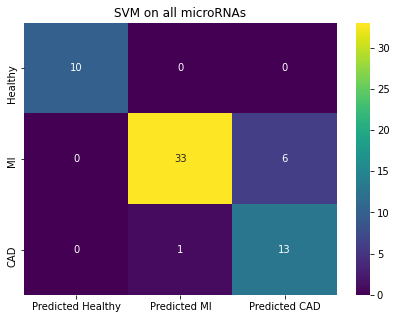

In [16]:
pred = random_search.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred,labels=['Healthy','MI', 'CAD'])
df_cm=pd.DataFrame(cm,index=[i for i in ['Healthy','MI', 'CAD']],columns=[i for i in ['Predicted Healthy','Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('SVM on all microRNAs')
sns.heatmap(df_cm,annot=True, cmap='viridis');

In [17]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         CAD       0.68      0.93      0.79        14
     Healthy       1.00      1.00      1.00        10
          MI       0.97      0.85      0.90        39

    accuracy                           0.89        63
   macro avg       0.88      0.92      0.90        63
weighted avg       0.91      0.89      0.89        63



## XGB

In [18]:
param_dist = {'n_estimators': [10, 25, 50, 75, 100, 150],
              'learning_rate': stats.uniform(0.1, 1.3), 
              'max_depth': [1, 2, 3] } 
random_search = RandomizedSearchCV( GradientBoostingClassifier(random_state=27), param_distributions=param_dist, n_iter=50, cv=10)
random_search.fit(X_train, y_train)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=27),
                   n_iter=50,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x119be6d90>,
                                        'max_depth': [1, 2, 3],
                                        'n_estimators': [10, 25, 50, 75, 100,
                                                         150]})

In [19]:
print('Model score on train set:')
print(random_search.score(X_train, y_train))
print('Model score on train set:')
print(random_search.score(X_test, y_test))

Model score on train set:
0.946524064171123
Model score on train set:
0.7936507936507936


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

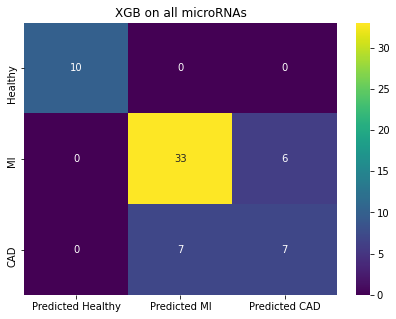

In [20]:
pred = random_search.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred,labels=['Healthy','MI', 'CAD'])
df_cm=pd.DataFrame(cm,index=[i for i in ['Healthy','MI', 'CAD']],columns=[i for i in ['Predicted Healthy','Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('XGB on all microRNAs')
sns.heatmap(df_cm,annot=True, cmap='viridis');

In [21]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         CAD       0.54      0.50      0.52        14
     Healthy       1.00      1.00      1.00        10
          MI       0.82      0.85      0.84        39

    accuracy                           0.79        63
   macro avg       0.79      0.78      0.78        63
weighted avg       0.79      0.79      0.79        63



# Feature selection using SelectFromModel

## XGB

In [22]:
XGB = GradientBoostingClassifier().fit(X_train, y_train)
importance = np.abs(XGB.feature_importances_)
feature_names = np.array(X_train.columns)
threshold = np.sort(importance)[-4] + 0.01
sfm = SelectFromModel(XGB, threshold=threshold).fit(X_train, y_train)
print("Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Features selected by SelectFromModel: ['7923976 / C1orf132///MIR29B2' '8008885 / MIR21' '8045453 / MIR128-1']


In [23]:
XGB.feature_importances_

array([0.1299447 , 0.22401746, 0.0975992 , 0.00436166, 0.17526945,
       0.17807494, 0.05918292, 0.10331467, 0.00462843, 0.02360657])

In [24]:
 X_train.columns

Index(['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '7971661 / MIR15A',
       '7976832 / MIR323A', '8008885 / MIR21', '8045453 / MIR128-1',
       '8084755 / MIR28', '8087881 / MIRLET7G', '8163107 / MIR32',
       '8175248 / MIR92A2'],
      dtype='object')

In [25]:
X3 = df[['7923976 / C1orf132///MIR29B2', '8008885 / MIR21', '8045453 / MIR128-1']]
y3 = df['MI status']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.25, random_state=27)

<IPython.core.display.Javascript object>

In [27]:
param_dist = {'n_estimators': [10, 25, 50, 75, 100, 150],
              'learning_rate': stats.uniform(0.1, 1.3), 
              'max_depth': [1, 2, 3] } 
random_search = RandomizedSearchCV( GradientBoostingClassifier(random_state=27), param_distributions=param_dist, n_iter=50, cv=10)
random_search.fit(X_train, y_train)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=27),
                   n_iter=50,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11a009e50>,
                                        'max_depth': [1, 2, 3],
                                        'n_estimators': [10, 25, 50, 75, 100,
                                                         150]})

In [28]:
print('Model score on train set:')
print(random_search.score(X_train, y_train))
print('Model score on train set:')
print(random_search.score(X_test, y_test))

Model score on train set:
0.8983957219251337
Model score on train set:
0.6349206349206349


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

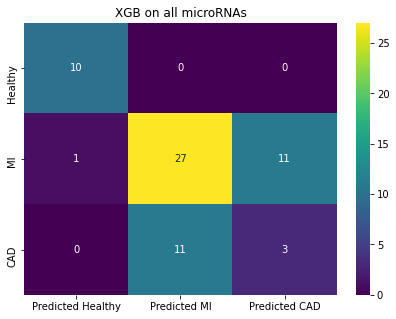

In [29]:
pred = random_search.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred,labels=['Healthy','MI', 'CAD'])
df_cm=pd.DataFrame(cm,index=[i for i in ['Healthy','MI', 'CAD']],columns=[i for i in ['Predicted Healthy','Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('XGB on all microRNAs')
sns.heatmap(df_cm,annot=True, cmap='viridis');

In [30]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         CAD       0.21      0.21      0.21        14
     Healthy       0.91      1.00      0.95        10
          MI       0.71      0.69      0.70        39

    accuracy                           0.63        63
   macro avg       0.61      0.64      0.62        63
weighted avg       0.63      0.63      0.63        63



# All 3 member combination of microRNAs

In [31]:
mirs=list(df.columns)
mirs.remove('MI status')
listOf3Combinations=[]
for i in range(len(mirs)):
  for j in range(i+1,len(mirs)):
    for k in range(j+1,len(mirs)):
       listOf3Combinations.append([mirs[i],mirs[j],mirs[k]])

len(listOf3Combinations)

120

## SVM

In [32]:
result3=[]
for i in range(len(listOf3Combinations)):
  X_temp = df[listOf3Combinations[i]]
  y_temp = df['MI status']
  X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=27)
  model = SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27)
  model.fit(X_train, y_train)
  result3.append([listOf3Combinations[i], model.score(X_train,y_train), model.score(X_test,y_test)])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
for j in range(len(result3)):
  if result3[j][1]>0.85 and result3[j][2]>0.85:
      print(result3[j])

[['7900488 / MIR30E', '7971661 / MIR15A', '8008885 / MIR21'], 0.8502673796791443, 0.8571428571428571]
[['7923976 / C1orf132///MIR29B2', '7971661 / MIR15A', '8008885 / MIR21'], 0.8556149732620321, 0.8571428571428571]
[['7971661 / MIR15A', '8008885 / MIR21', '8084755 / MIR28'], 0.8823529411764706, 0.8571428571428571]
[['7976832 / MIR323A', '8008885 / MIR21', '8084755 / MIR28'], 0.8556149732620321, 0.873015873015873]
[['8008885 / MIR21', '8084755 / MIR28', '8087881 / MIRLET7G'], 0.8609625668449198, 0.8571428571428571]
[['8008885 / MIR21', '8087881 / MIRLET7G', '8175248 / MIR92A2'], 0.8609625668449198, 0.873015873015873]


### Random search on the best combinations

#### [['8008885 / MIR21', '8087881 / MIRLET7G', '8175248 / MIR92A2'], 0.8609625668449198, 0.873015873015873]

In [112]:
X_temp = df[['8008885 / MIR21', '8087881 / MIRLET7G', '8175248 / MIR92A2']]
y_temp = df['MI status']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=27)

<IPython.core.display.Javascript object>

In [114]:
svm=SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27)
svm.fit(X_train, y_train)

SVC(C=1000, gamma=0.05, random_state=27)

In [115]:
print('Model score on train set:')
print(svm.score(X_train, y_train))
print('Model score on train set:')
print(svm.score(X_test, y_test))

Model score on train set:
0.8609625668449198
Model score on train set:
0.873015873015873


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

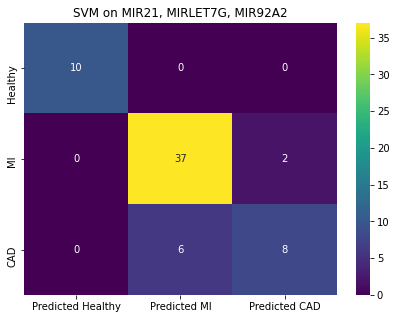

In [116]:
pred = svm.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred,labels=['Healthy','MI', 'CAD'])
df_cm=pd.DataFrame(cm,index=[i for i in ['Healthy','MI', 'CAD']],columns=[i for i in ['Predicted Healthy','Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('SVM on MIR21, MIRLET7G, MIR92A2')
sns.heatmap(df_cm,annot=True, cmap='viridis');

In [117]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         CAD       0.80      0.57      0.67        14
     Healthy       1.00      1.00      1.00        10
          MI       0.86      0.95      0.90        39

    accuracy                           0.87        63
   macro avg       0.89      0.84      0.86        63
weighted avg       0.87      0.87      0.87        63



In [118]:
label = LabelEncoder()

y_temp = label.fit_transform(df['MI status'])
y_temp = pd.get_dummies(y_temp)
y_temp.columns = ['CAD', 'Healthy', 'MI']

n_classes = y_temp.shape[1]

<IPython.core.display.Javascript object>

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=.25, random_state=27)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-121-29f60df68002>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


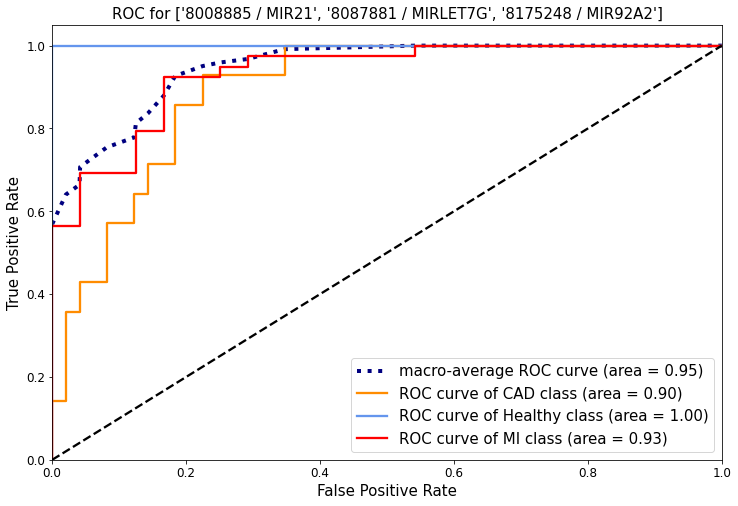

In [121]:
lw = 2.3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(['darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} class (area = {1:0.2f})'
             ''.format(list(y_temp.columns)[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC for {0}'''.format(list(X_temp.columns)), fontsize = 15)
plt.legend(loc="lower right", prop={'size':15})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("MIR21, MIRLET7G, MIR92A2.pdf")

#### [['7971661 / MIR15A', '8008885 / MIR21', '8084755 / MIR28'], 0.8823529411764706, 0.8571428571428571]

In [122]:
X_temp = df[['7971661 / MIR15A', '8008885 / MIR21', '8084755 / MIR28']]
y_temp = df['MI status']

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=27)

<IPython.core.display.Javascript object>

In [124]:
svm=SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27)
svm.fit(X_train, y_train)

SVC(C=1000, gamma=0.05, random_state=27)

In [125]:
print('Model score on train set:')
print(svm.score(X_train, y_train))
print('Model score on train set:')
print(svm.score(X_test, y_test))

Model score on train set:
0.8823529411764706
Model score on train set:
0.8571428571428571


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

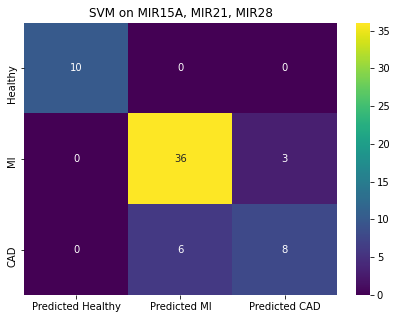

In [126]:
pred = svm.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred,labels=['Healthy','MI', 'CAD'])
df_cm=pd.DataFrame(cm,index=[i for i in ['Healthy','MI', 'CAD']],columns=[i for i in ['Predicted Healthy','Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('SVM on MIR15A, MIR21, MIR28')
sns.heatmap(df_cm,annot=True, cmap='viridis');

In [127]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         CAD       0.73      0.57      0.64        14
     Healthy       1.00      1.00      1.00        10
          MI       0.86      0.92      0.89        39

    accuracy                           0.86        63
   macro avg       0.86      0.83      0.84        63
weighted avg       0.85      0.86      0.85        63



In [128]:
label = LabelEncoder()

y_temp = label.fit_transform(df['MI status'])
y_temp = pd.get_dummies(y_temp)
y_temp.columns = ['CAD', 'Healthy', 'MI']

n_classes = y_temp.shape[1]

<IPython.core.display.Javascript object>

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=.25, random_state=27)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-130-ce10c962a8b5>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


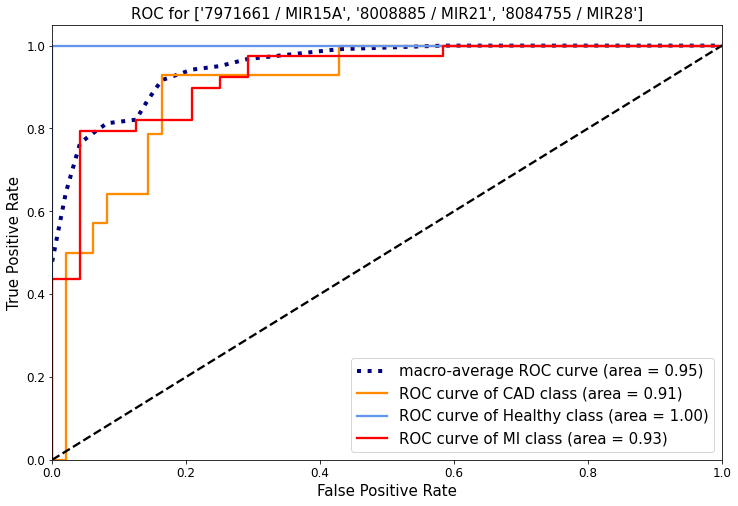

In [130]:
lw = 2.3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)


colors = cycle(['darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} class (area = {1:0.2f})'
             ''.format(list(y_temp.columns)[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC for {0}'''.format(list(X_temp.columns)), fontsize = 15)
plt.legend(loc="lower right", prop={'size':15})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("MIR15A, MIR21, MIR28.pdf")

#### ['7900488 / MIR30E', '8008885 / MIR21', '8084755 / MIR28']

In [131]:
X_temp = df[['7900488 / MIR30E', '8008885 / MIR21', '8084755 / MIR28']]
y_temp = df['MI status']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=27)

<IPython.core.display.Javascript object>

In [133]:
svm=SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27)
svm.fit(X_train, y_train)

SVC(C=1000, gamma=0.05, random_state=27)

In [134]:
print('Model score on train set:')
print(svm.score(X_train, y_train))
print('Model score on train set:')
print(svm.score(X_test, y_test))

Model score on train set:
0.8770053475935828
Model score on train set:
0.8095238095238095


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

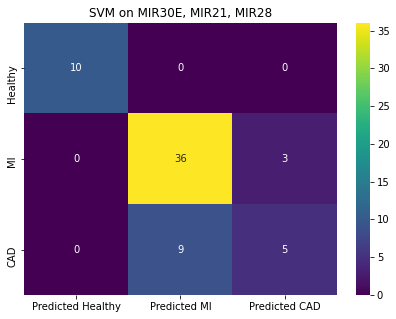

In [135]:
pred = svm.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred,labels=['Healthy','MI', 'CAD'])
df_cm=pd.DataFrame(cm,index=[i for i in ['Healthy','MI', 'CAD']],columns=[i for i in ['Predicted Healthy','Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('SVM on MIR30E, MIR21, MIR28')
sns.heatmap(df_cm,annot=True, cmap='viridis');

In [136]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         CAD       0.62      0.36      0.45        14
     Healthy       1.00      1.00      1.00        10
          MI       0.80      0.92      0.86        39

    accuracy                           0.81        63
   macro avg       0.81      0.76      0.77        63
weighted avg       0.79      0.81      0.79        63



In [137]:
label = LabelEncoder()

y_temp = label.fit_transform(df['MI status'])
y_temp = pd.get_dummies(y_temp)
y_temp.columns = ['CAD', 'Healthy', 'MI']

n_classes = y_temp.shape[1]

<IPython.core.display.Javascript object>

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=.25, random_state=27)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-139-39cfba646c05>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


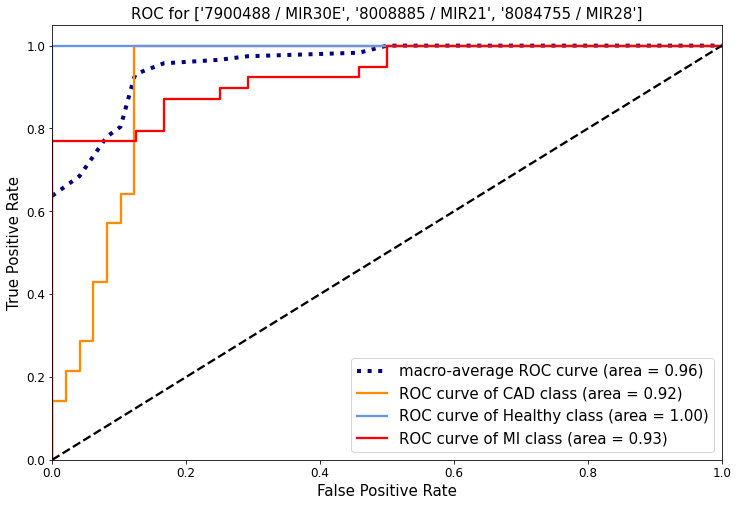

In [139]:
lw = 2.3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(['darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} class (area = {1:0.2f})'
             ''.format(list(y_temp.columns)[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC for {0}'''.format(list(X_temp.columns)), fontsize = 15)
plt.legend(loc="lower right", prop={'size':15})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("MIR30E, MIR21, MIR28.pdf")

#### ['7976832 / MIR323A', '8008885 / MIR21', '8084755 / MIR28']

In [140]:
X_temp = df[['7976832 / MIR323A', '8008885 / MIR21', '8084755 / MIR28']]
y_temp = df['MI status']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=27)

<IPython.core.display.Javascript object>

In [142]:
svm=SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27)
svm.fit(X_train, y_train)

SVC(C=1000, gamma=0.05, random_state=27)

In [143]:
print('Model score on train set:')
print(svm.score(X_train, y_train))
print('Model score on train set:')
print(svm.score(X_test, y_test))

Model score on train set:
0.8556149732620321
Model score on train set:
0.873015873015873


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

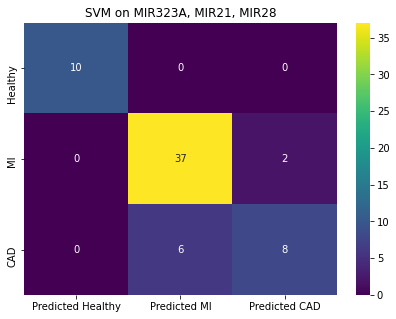

In [144]:
pred = svm.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred,labels=['Healthy','MI', 'CAD'])
df_cm=pd.DataFrame(cm,index=[i for i in ['Healthy','MI', 'CAD']],columns=[i for i in ['Predicted Healthy','Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('SVM on MIR323A, MIR21, MIR28')
sns.heatmap(df_cm,annot=True, cmap='viridis');

In [145]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         CAD       0.80      0.57      0.67        14
     Healthy       1.00      1.00      1.00        10
          MI       0.86      0.95      0.90        39

    accuracy                           0.87        63
   macro avg       0.89      0.84      0.86        63
weighted avg       0.87      0.87      0.87        63



In [146]:
label = LabelEncoder()

y_temp = label.fit_transform(df['MI status'])
y_temp = pd.get_dummies(y_temp)
y_temp.columns = ['CAD', 'Healthy', 'MI']

n_classes = y_temp.shape[1]

<IPython.core.display.Javascript object>

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=.25, random_state=27)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-149-b201a64b14f4>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


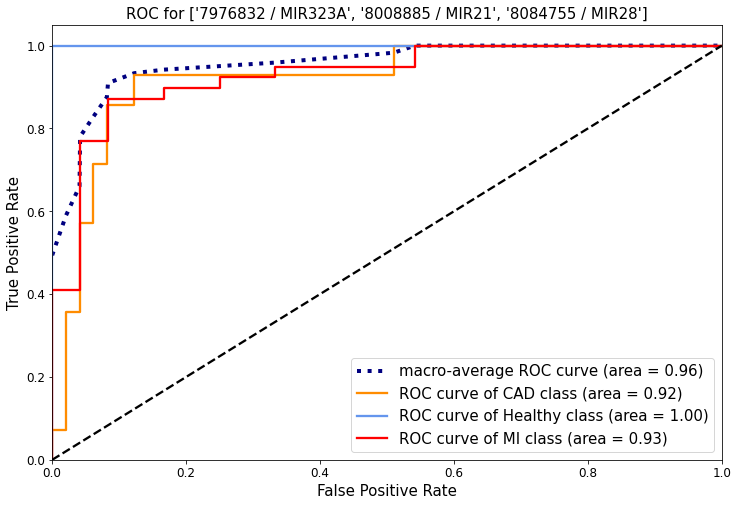

In [149]:
lw = 2.3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(['darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} class (area = {1:0.2f})'
             ''.format(list(y_temp.columns)[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC for {0}'''.format(list(X_temp.columns)), fontsize = 15)
plt.legend(loc="lower right", prop={'size':15})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("MIR323A, MIR21, MIR28.pdf")

# XGB

In [ ]:
result3=[]
for i in range(len(listOf3Combinations)):
  X = df[listOf3Combinations[i]]
  y = df['MI status']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
  model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=27)
  model.fit(X_train, y_train)
  result3.append([listOf3Combinations[i], model.score(X_train,y_train), model.score(X_test,y_test)])

In [ ]:
for j in range(len(result3)):
  if result3[j][1]>0.80 and result3[j][2]>0.80:
      print(result3[j])

In [ ]:
X = df[['7900488 / MIR30E', '8008885 / MIR21', '8084755 / MIR28']]
y = df['MI status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

 ## Random Search XGB

### XGB

param_dist = {
  'n_estimators': [10, 25, 50, 75, 100, 150],
  'learning_rate': stats.uniform(0.1, 1.3),
  'max_depth': [1, 2, 3]
}
random_search = RandomizedSearchCV(
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=27), param_distributions=param_dist, n_iter=50)

In [ ]:
### SVM
param_dist = {
  'C': stats.uniform(0.1, 1e4),
  'gamma': loguniform(1e-6, 1e+1)
}

random_search = RandomizedSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_distributions=param_dist, n_iter=30, cv=10)


In [ ]:
random_search.fit(X_train, y_train)

In [ ]:
random_search.score(X_train, y_train)

In [ ]:
random_search.score(X_test, y_test)

In [ ]:
y_test

In [ ]:
pred = random_search.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred,labels=['Healthy','MI', 'CAD'])
df_cm=pd.DataFrame(cm,index=[i for i in ['Healthy','MI', 'CAD']],columns=[i for i in ['Predicted Healthy','Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
sns.heatmap(df_cm,annot=True, cmap='viridis');

In [ ]:
print(classification_report(y_test,pred))